<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=25% ALIGN="right">
</figure>

<p><div> 
<br><b>Monitoring of Structural Health and Geohazards</b>
<br><b>CEGM2008</b>
<br> Faculty of Civil Engineering and Geosciences - Delft University of Technology 
<br><b>Responsible instructor:</b>
<br><i>- Eliz-Mari Lourens</i>
</div>
<br><b>Notebooks created by teaching assistants:</b>
<br><i>- Siemen Algra</i>
<br><i>- Heisuke Miyoshi</i>
</div>


# 3.1a Full-order solution in the frequency domain
    
This notebook calculates the dynamic response of the cantilever beam to two transient forces. Please make sure you have the package "model.py" stored in the same folder as this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft

In [2]:
# Import custom-made package containing the FE model of the beam
import model

Eigenfrequencies [Hz]:

[  21.0222448   131.74442861  368.89347935  722.91731257 1195.16190219
 1785.73125816 2494.98951148 3323.53528584 4272.28557265 5342.55488575]


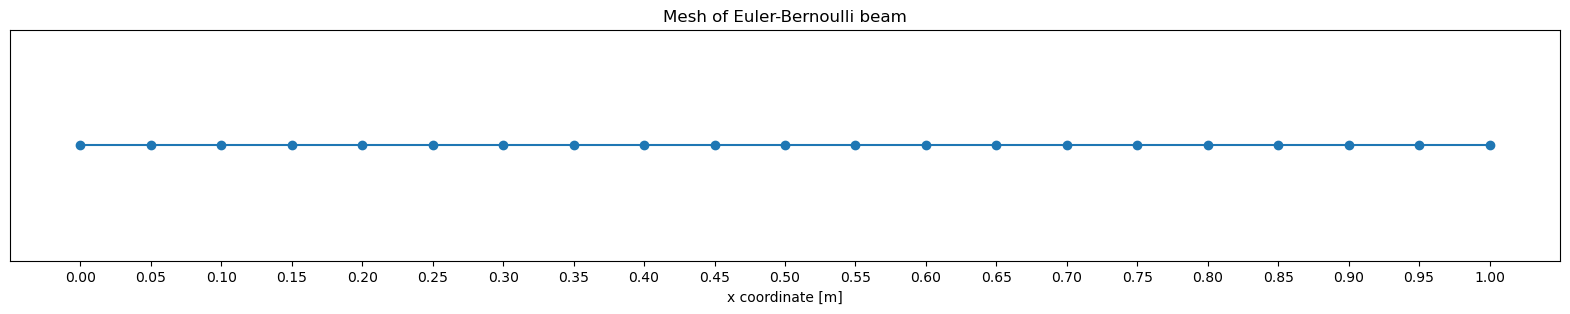

In [3]:
# Load the properties of the FE model of the beam
M, K, Phi, Omega, n_elements, n_nodes, n_dofs = model.get_M_and_K_matrix()

In [4]:
# Construct the damping matrix assuming modal damping
xi = 0.05  # Constant modal damping ratio assumed

# Create damping matrix
Cstar = np.diag(2*Omega*xi)
C_matrix = M @ Phi @ Cstar @ Phi.T @ M

In [5]:
# Choose sampling parameters
N = int(2**12)
dt = 0.0005
t= np.arange(0, N*dt, dt) #time axis

# To create the frequency axis (for plotting)
F = 1/dt
df = F/N
freq = np.arange(0, F/2, df)


# Create empty force arrays to fill up
p1 = np.zeros(len(t))

# Add a triangular pulse to the first force array
for i, k in enumerate(t):
    if 0.02 <= k <= 0.04:
        p1[i] = 200 / (0.04-0.02) * (k-0.02)
    elif 0.04 < k <= 0.06:
        p1[i] = 200 - 200/(0.06-0.04) * (k-0.04)
    else:
        p1[i]=0
        
# Since the second force array is exactly the same as the first but half of the force amplitude, we can just divide the first array by 2
p2 = p1/2

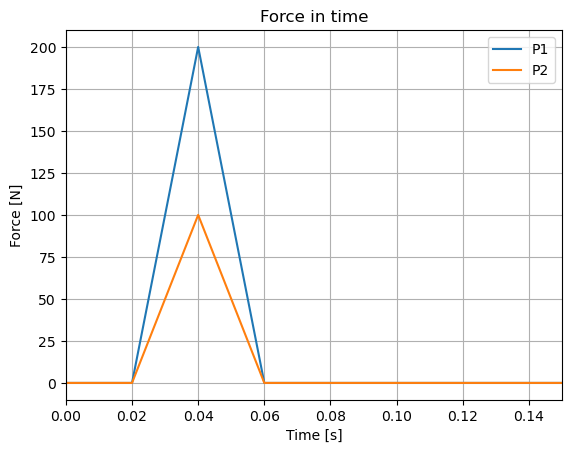

In [6]:
# Visualize the force arrays in time 
plt.figure()
plt.title('Force in time')
plt.ylabel('Force [N]')
plt.xlabel('Time [s]')
plt.plot(t, p1, label='P1')
plt.plot(t, p2, label='P2')
plt.legend()
plt.grid()
plt.xlim(0, 0.15);

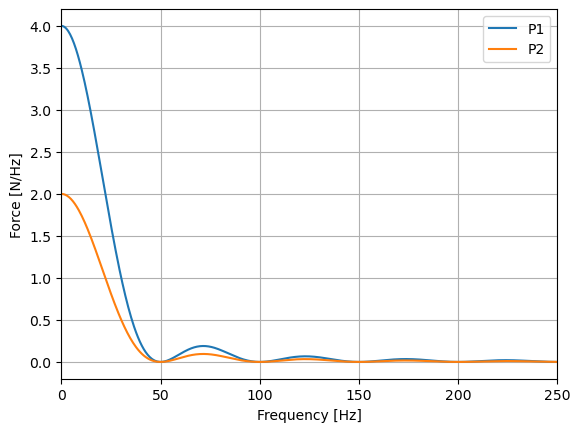

In [7]:
# Apply fast fourier to transform force data to frequency domain
p1_omega = fft(p1)
p2_omega = fft(p2)
p_omega = -np.vstack((p1_omega, p2_omega))

# Plot using the frequency axis you defined above (only for positive frequencies)
plt.plot(freq, np.abs(p1_omega[0:N//2])*dt, label='P1')
plt.plot(freq, np.abs(p2_omega[0:N//2])*dt, label='P2')
plt.xlim(0, 250)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Force [N/Hz]')
plt.grid()

In [8]:
# Construct a boolean selection vector for specifying the force locations
S = np.zeros((40, 2))
# P1 is applied to node 18 and P2 is applied on the node 20 (last node)
# The DOF of vertical displacement comes before the DOF of rotation for each node
S[34,0] = 1
S[-2,1] = 1


In [9]:
# Solve
N_counter = int(N/2)
u_omega = np.zeros((n_dofs, N_counter), dtype=np.complex128)

for ind in range(N_counter):
    omega = freq[ind] * 2 * np.pi
    # Construct the transfer function matrix H [nDOF x nDOF]
    H = np.linalg.inv(-omega**2*M + 1j*omega*C_matrix + K)
    
    # Solve for the displacement vector in the frequency domain
    u_omega[:, ind] = H @ S@ p_omega[:, ind]
    
# Extend the displacement frequency spectra to include also the negative frequencies (conjugation property)
#u_omega = np.concatenate((u_omega, np.zeros((n_dofs, 1)), np.conj(u_omega[:, ::-1][:, 1:])), axis=1)
#u_omega = np.concatenate((u_omega, np.conj(u_omega)), axis=1)
u_omega = np.hstack((u_omega, np.zeros((n_dofs, 1), dtype=complex), np.conj(u_omega[:, 1:][:, ::-1])))

In [10]:
# Applying inverse FFT to get the displacement in time domain
u = np.fft.ifft(u_omega, axis=1)

# Transposing the array for plotting later
u = u.transpose()
u_omega = u_omega.transpose()

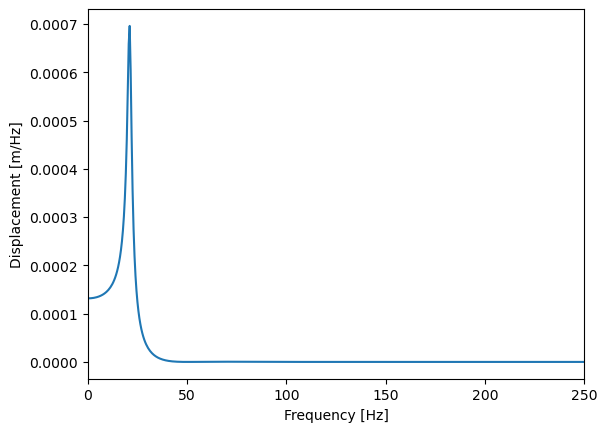

In [11]:
# Plot the displacement of the last node in the frequency domain
u_omega_tip = u_omega[:, -2].transpose()
plt.xlim(0, 250)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Displacement [m/Hz]')
# 
plt.plot(freq, np.abs(u_omega_tip[0:N//2])*dt);

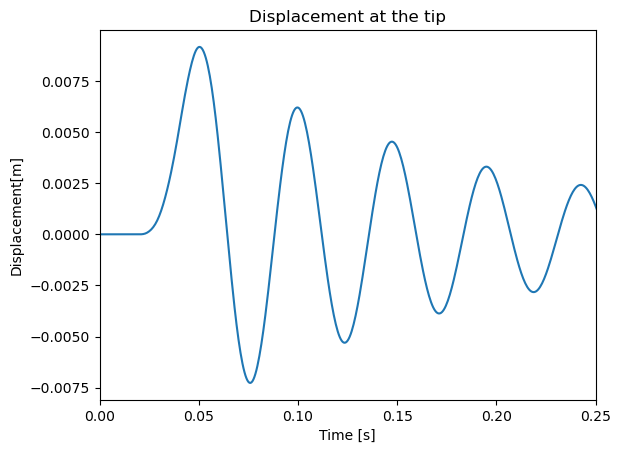

In [12]:
# Plot the displacement of the last node in the time domain
# Only use the real part of the solution
u_tip = -u[:, -2].real
plt.plot(t, u_tip)
plt.xlim(0, 0.25)
plt.title("Displacement at the tip")
plt.xlabel("Time [s]")
plt.ylabel("Displacement[m]");

In [13]:
# Creating the animation of the displacements of the beam
n_nodes_free = n_nodes - 1
%matplotlib inline
from ipywidgets import interact, fixed, widgets

def disp_plot(x, u, step):
    fig = plt.figure()
    ax = plt.axes(xticks=np.arange(0, 21, 1), ylim=(-1.5e-2, 1.5e-2), yticks=[])
    ax.plot(x, u[step, ::2])
    plt.xlabel('x')
    plt.ylabel('Displacement')
    plt.show()

In [14]:
# Showing the animation of the displacements of the beam   
play = widgets.Play(min=0, max=len(t)-1, step=1, value=0, interval=50, disabled=False)
slider = widgets.IntSlider(min=0, max=len(t)-1, step=1, value=0)
widgets.jslink((play, 'value'), (slider, 'value'))
interact(disp_plot,
         x=fixed(np.arange(1, n_nodes_free+1)),
         u=fixed(u.real),
         step = play)
widgets.HBox([slider])

interactive(children=(Play(value=0, description='step', interval=50, max=4095), Output()), _dom_classes=('widg…

In [15]:
# Filtering Phi to the 1-3rd eigenmodes and the vertical displacements
mode_1 = Phi[::2, 0]
mode_2 = Phi[::2, 1]
mode_3 = Phi[::2, 2]

In [16]:
# Use the Mode animator from the custom package and visualise the eigenmodes
model.Mode_animation_plotter(mode_1, mode_2, mode_3, n_nodes_free)

interactive(children=(Play(value=0, description='step', max=39), Output()), _dom_classes=('widget-interact',))

interactive(children=(Play(value=0, description='step', max=39), Output()), _dom_classes=('widget-interact',))

interactive(children=(Play(value=0, description='step', max=39), Output()), _dom_classes=('widget-interact',))

# 3.1b Reduced-order solution in the frequency domain
    
Now re-calculate the dynamic response of the cantilever beam to the two transient forces, but this time using modal superposition.

In [17]:
# Solve
n_modes = 5 # Number of modeswith which to calculate a solution

# Transfer forces to modal coordinates
#p_omega_modal = np.dot(Phi[:, :n_modes].T, np.dot(S, p_omega))
p_omega_modal = Phi[:, :n_modes].T@S@p_omega
print("Shape Phi:", Phi.shape)
print("Shape S:", S.shape)
print("Shape p_omega:", p_omega.shape)

# Abbreviation 'ms' for modal superposition
u_omega_ms = np.zeros((n_dofs, int(N/2)), dtype=complex) # Displacements in frequency domain
h = np.zeros((n_modes, N//2), dtype=complex) # Modal transfer functions
z = np.zeros((n_modes, N//2), dtype=complex) # Modal displacements

for ind in range(int(N/2)):
    omega = freq[ind] * 2 * np.pi
    
    for j in range(n_modes):
        h[j, ind] = 1 / (-omega**2 + 2j * omega * Omega[j] * xi + Omega[j]**2)
        z[j, ind] = h[j, ind] * p_omega_modal[j, ind]

#u_omega_ms = np.dot(Phi[:, :n_modes], z)
u_omega_ms = Phi[:, :n_modes]@z
u_omega_ms = np.hstack((u_omega_ms, np.zeros((n_dofs, 1), dtype=complex), np.conj(u_omega_ms[:, 1:][:, ::-1])))

Shape Phi: (40, 40)
Shape S: (40, 2)
Shape p_omega: (2, 4096)


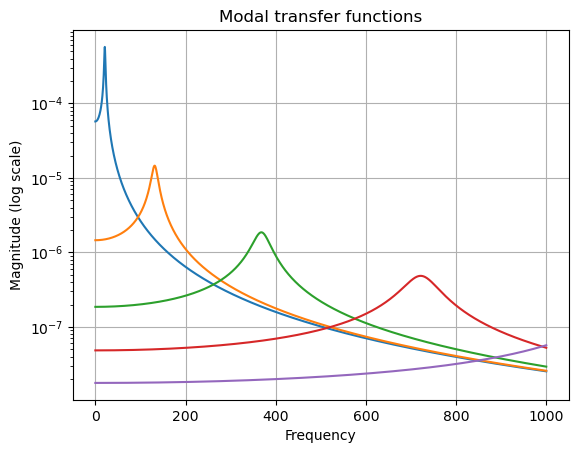

In [18]:
# Plot the modal transfer functions
plt.figure()
plt.semilogy(freq[:N//2], np.abs(h).T)
plt.title('Modal transfer functions')
plt.xlabel('Frequency')
plt.ylabel('Magnitude (log scale)')
plt.grid(True)

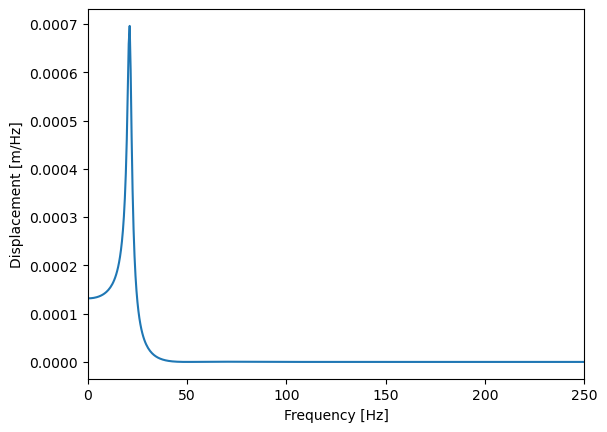

In [19]:
# applying inverse FFT to get the displacement in time domain
u_ms = np.fft.ifft(u_omega_ms, axis=1)

# Transposing for plotting
u_ms = u_ms.transpose()
u_omega_ms = u_omega_ms.transpose()

# Plot the displacement of the last node in the frequency domain
u_omega_tip_ms = u_omega_ms[:, -2]
plt.xlim(0, 250)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Displacement [m/Hz]')
plt.plot(freq, np.abs(u_omega_tip_ms[0:N//2])*dt);

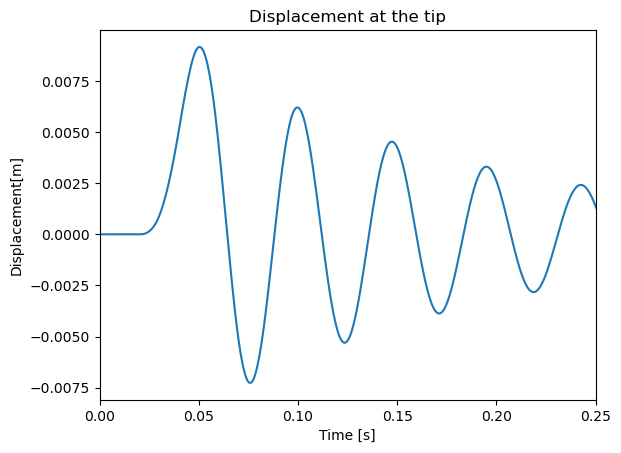

In [20]:
# Plot the displacement of the last node in the time domain
# Only use the real part of the solution
u_tip_ms = -u_ms[:, -2].real

plt.plot(t, u_tip_ms)
plt.xlim(0, 0.25)
plt.title("Displacement at the tip")
plt.xlabel("Time [s]")
plt.ylabel("Displacement[m]");